In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import spacy
from tqdm import tqdm
import tensorflow as tf
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

2024-10-24 11:08:44.564310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 11:08:45.114188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 11:08:45.239778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 11:08:46.117278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 11:08:51.756312: W tensorflow/comp

In [1]:
import pandas as pd

train_data = pd.read_csv('train_data.csv')
test_duplicate_data = pd.read_csv('test_data.csv')
valid_data = pd.read_csv('valid_data.csv')

In [2]:
test_duplicate_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos,combined_text
0,You could forgive Apple's legal team for comin...,0,you could forgive apples legal team for coming...,you could forgive apple legal team for come ac...,you could forgiv appl legal team for come acro...,PRON AUX VERB NOUN ADJ NOUN ADP VERB ADP DET A...,you could forgive apples legal team for coming...
1,Liberal and conservative are two different way...,1,liberal and conservative are two different way...,liberal and conservative be two different way ...,liber and conserv are two differ way of think ...,ADJ CCONJ ADJ AUX NUM ADJ NOUN ADP VERB ADP NO...,liberal and conservative are two different way...
2,The sun is also white . It just appears yellow...,0,the sun is also white it just appears yellow next,the sun be also white it just appear yellow next,the sun is also white it just appear yellow next,DET NOUN AUX ADV ADJ PRON ADV VERB ADJ ADP,the sun is also white it just appears yellow n...
3,North Lanarkshire Council in Scotland has laun...,1,north lanarkshire council in scotland has laun...,north lanarkshire council in scotland have lau...,north lanarkshir council in scotland has launc...,PROPN PROPN PROPN ADP PROPN AUX VERB DET NOUN ...,north lanarkshire council in scotland has laun...
4,"""I was looking for something that was comparab...",0,i was looking for something that was comparabl...,I be look for something that be comparable for...,i was look for someth that was compar for my p...,PRON AUX VERB ADP PRON PRON AUX ADJ ADP PRON NOUN,i was looking for something that was comparabl...
...,...,...,...,...,...,...,...
14835,These Vienna talks for the first time include ...,0,these vienna talks for the first time include ...,these vienna talk for the first time include a...,these vienna talk for the first time includ al...,DET NOUN VERB ADP DET ADJ NOUN VERB DET DET AD...,these vienna talks for the first time include ...
14836,India's film censorship board has granted a ce...,1,indias film censorship board has granted a cer...,indias film censorship board have grant a cert...,india film censorship board has grant a certif...,PROPN PROPN NOUN NOUN AUX VERB DET NOUN ADP DE...,indias film censorship board has granted a cer...
14837,"Expanding ammunition, also known as hollow poi...",1,expanding ammunition also known as hollow poin...,expand ammunition also know as hollow point bu...,expand ammunit also known as hollow point bull...,VERB NOUN ADV VERB ADP ADJ NOUN NOUN AUX VERB ...,expanding ammunition also known as hollow poin...
14838,They will have in-depth discussions on relatio...,0,they will have indepth discussions on relation...,they will have indepth discussion on relation ...,they will have indepth discuss on relat betwee...,PRON AUX VERB ADJ NOUN ADP NOUN ADP DET NUM NO...,they will have indepth discussions on relation...


In [3]:
train_x, test_x, train_y, test_y = train_data['combined_text'], test_duplicate_data['combined_text'], train_data['label'], test_duplicate_data['label']
train_x, valid_x, train_y, valid_y = train_data['combined_text'], valid_data['combined_text'], train_data['label'], valid_data['label']

In [4]:
# TF-IDF Vectorization using all combined text features
tfidf = TfidfVectorizer(max_features=1000)
train_x_tfidf = tfidf.fit_transform(train_x).toarray()
valid_x_tfidf = tfidf.transform(valid_x).toarray()
test_x_tfidf = tfidf.transform(test_x).toarray()

# Convert labels to numpy arrays
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_x_tfidf, train_y)).batch(64).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x_tfidf, valid_y)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x_tfidf, test_y)).batch(64).prefetch(tf.data.AUTOTUNE)

2024-10-24 11:09:32.392958: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


2024-10-21 16:53:20.757647: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2968040000 exceeds 10% of free system memory.


4638/4638 ━━━━━━━━━━━━━━━━━━━━ 941s 203ms/step - accuracy: 0.7533 - loss: 0.4607 - val_accuracy: 0.8362 - val_loss: 0.3222
Epoch 2/5
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 946s 204ms/step - accuracy: 0.8447 - loss: 0.3100 - val_accuracy: 0.8405 - val_loss: 0.3076
Epoch 3/5
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 943s 203ms/step - accuracy: 0.8650 - loss: 0.2722 - val_accuracy: 0.8413 - val_loss: 0.3063
Epoch 4/5
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 938s 202ms/step - accuracy: 0.8810 - loss: 0.2444 - val_accuracy: 0.8395 - val_loss: 0.3066
Epoch 5/5
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 943s 203ms/step - accuracy: 0.8902 - loss: 0.2290 - val_accuracy: 0.8388 - val_loss: 0.3245
516/516 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step
Validation Accuracy:  0.8388309483385884
Validation F1 Score:  0.8080589254766031
Validation MCC:  0.6704504136024475
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      9344
           1       0.84      0.78      0.81      7148

    accuracy        

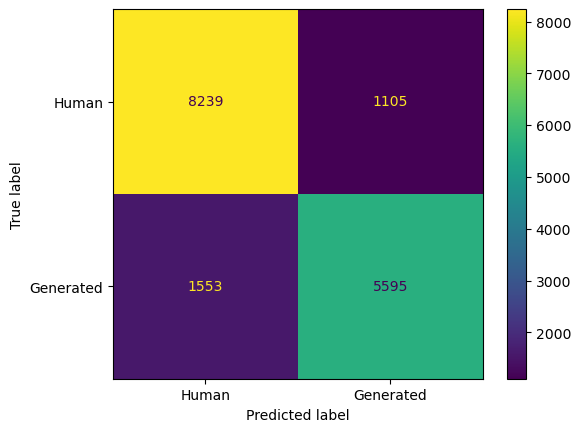

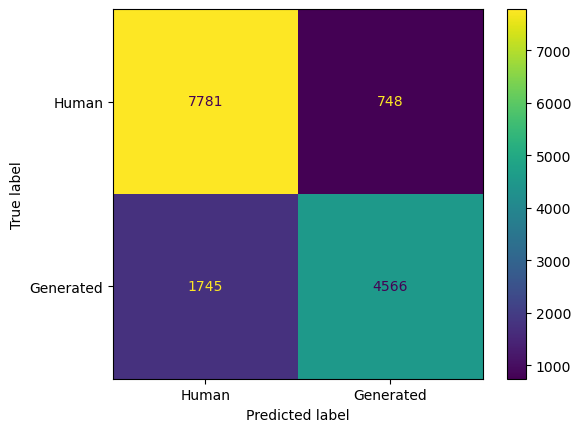

In [11]:
### CNN Model

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
    classification_report, f1_score, matthews_corrcoef
)

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(train_x_tfidf.shape[1], 1)))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(1, activation='sigmoid'))  

model_CNN.compile(loss='binary_crossentropy',  
                  optimizer='adam',
                  metrics=['accuracy'])

train_x_tfidf_reshaped = train_x_tfidf.reshape((train_x_tfidf.shape[0], train_x_tfidf.shape[1], 1))
valid_x_tfidf_reshaped = valid_x_tfidf.reshape((valid_x_tfidf.shape[0], valid_x_tfidf.shape[1], 1))
test_x_tfidf_reshaped = test_x_tfidf.reshape((test_x_tfidf.shape[0], test_x_tfidf.shape[1], 1))

model_CNN.fit(train_x_tfidf_reshaped, train_y, validation_data=(valid_x_tfidf_reshaped, valid_y), epochs=5)

valid_pred_y = (model_CNN.predict(valid_x_tfidf_reshaped) > 0.5).astype("int32").flatten()

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid_cnn = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid_cnn.plot()

report_cnn_valid = classification_report(valid_y, valid_pred_y)
print(report_cnn_valid)

test_pred_y = (model_CNN.predict(test_x_tfidf_reshaped) > 0.5).astype("int32").flatten()

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_cnn_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_cnn_test.plot()

report_cnn_test = classification_report(test_y, test_pred_y)
print(report_cnn_test)


In [12]:
model_CNN.save('model_CNN_Traditional.h5')

Epoch 1/5


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-21 18:12:45.207026: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5936080000 exceeds 10% of free system memory.


2319/2319 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7107 - loss: 0.5069 - val_accuracy: 0.7328 - val_loss: 0.9536
Epoch 2/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7692 - loss: 0.4287 - val_accuracy: 0.7524 - val_loss: 0.9929
Epoch 3/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7948 - loss: 0.3896 - val_accuracy: 0.7582 - val_loss: 1.0391
Epoch 4/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8133 - loss: 0.3618 - val_accuracy: 0.7650 - val_loss: 1.0287
Epoch 5/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8259 - loss: 0.3410 - val_accuracy: 0.7738 - val_loss: 1.0386
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Accuracy:  0.7737691001697793
Validation F1 Score:  0.6703189891313952
Validation MCC:  0.5591565226998777
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83      9344
           1       0.91      0.53      0.67      7148

  

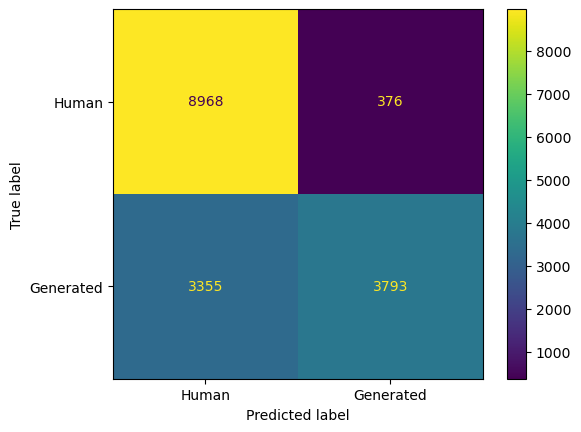

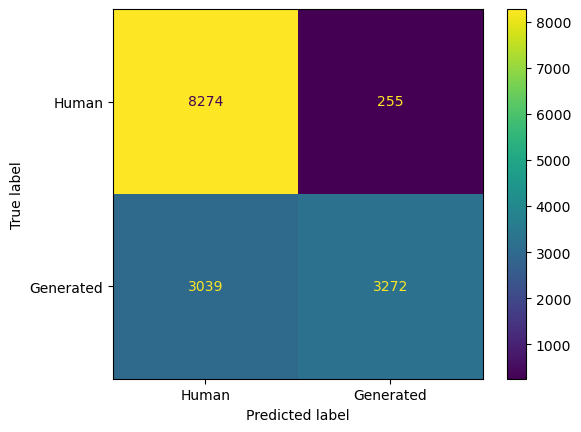

In [13]:
### LSTM model

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)

model_LSTM = Sequential()
model_LSTM.add(Dense(128, activation='relu', input_shape=(train_x_tfidf.shape[1],)))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_LSTM.fit(train_dataset, validation_data=valid_dataset, epochs=5)

valid_pred_y = (model_LSTM.predict(valid_dataset) > 0.5).astype("int32").flatten()
f1_valid = f1_score(valid_y, valid_pred_y)
mcc_valid = matthews_corrcoef(valid_y, valid_pred_y)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_valid)
print("Validation MCC: ", mcc_valid)

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = (model_LSTM.predict(test_dataset) > 0.5).astype("int32").flatten()
f1_test = f1_score(test_y, test_pred_y)
mcc_test = matthews_corrcoef(test_y, test_pred_y)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_test)
print("Test MCC: ", mcc_test)

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)


In [14]:
model_LSTM.save('model_LSTM_Traditional.h5')

Epoch 1/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7163 - loss: 0.5337 - val_accuracy: 0.7251 - val_loss: 1.0087
Epoch 2/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7662 - loss: 0.4348 - val_accuracy: 0.7342 - val_loss: 1.1193
Epoch 3/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8074 - loss: 0.3771 - val_accuracy: 0.7430 - val_loss: 1.2882
Epoch 4/5
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8450 - loss: 0.3170 - val_accuracy: 0.7529 - val_loss: 1.3833


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy:  0.7251394615571186
Validation F1 Score:  0.5741662752465947
Validation MCC:  0.46109487481673633
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80      9344
           1       0.87      0.43      0.57      7148

    accuracy                           0.73     16492
   macro avg       0.78      0.69      0.69     16492
weighted avg       0.77      0.73      0.70     16492

232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy:  0.7409029649595688
Test F1 Score:  0.5940238623165452
Test MCC:  0.4891436416123728
Test Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.96      0.81      8529
           1       0.89      0.45      0.59      6311

    accuracy                           0.74     14840
   macro avg       0.80      0.70      0.70     14840
weighted avg       0.78      0.74   

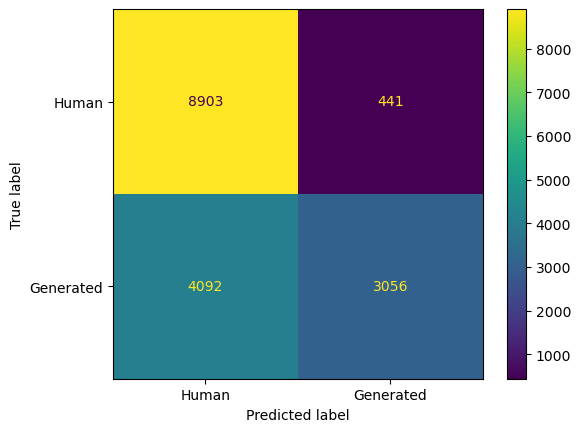

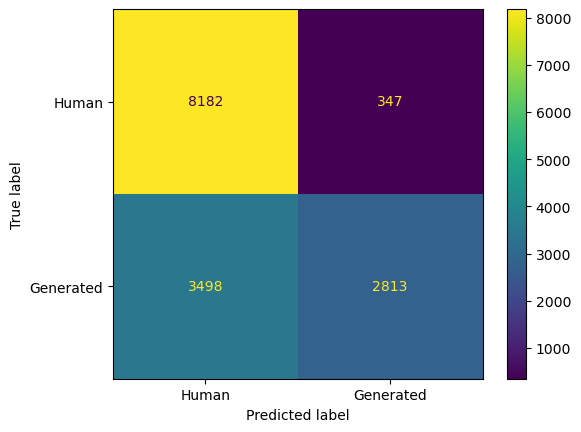

In [15]:
### RNN model

import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_x_tfidf.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model_RNN.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model_RNN.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

model_RNN.save('model_RNN_Traditional.h5')

valid_pred_prob = model_RNN.predict(valid_dataset)
valid_pred_y = (valid_pred_prob > 0.5).astype(int).flatten()

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_prob = model_RNN.predict(test_dataset)
test_pred_y = (test_pred_prob > 0.5).astype(int).flatten()

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)


In [ ]:
print(a)

Validation Accuracy:  0.7835920446276983
Validation F1 Score:  0.7493151647116668
Validation MCC:  0.5589586478781453
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      9344
           1       0.75      0.75      0.75      7148

    accuracy                           0.78     16492
   macro avg       0.78      0.78      0.78     16492
weighted avg       0.78      0.78      0.78     16492

Test Accuracy:  0.771832884097035
Test F1 Score:  0.7267591994835377
Test MCC:  0.5312862586632842
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      8529
           1       0.74      0.71      0.73      6311

    accuracy                           0.77     14840
   macro avg       0.77      0.76      0.77     14840
weighted avg       0.77      0.77      0.77     14840



['svm_model_Traditional.joblib']

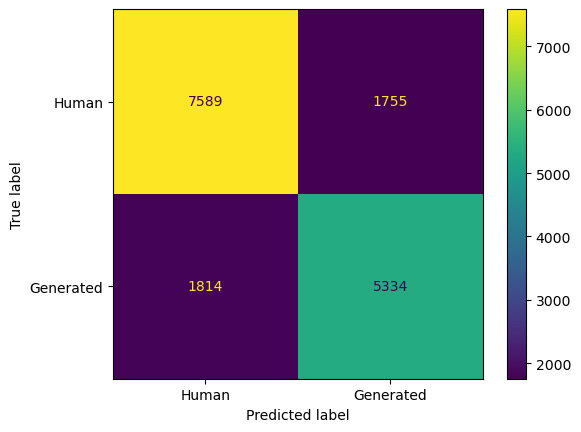

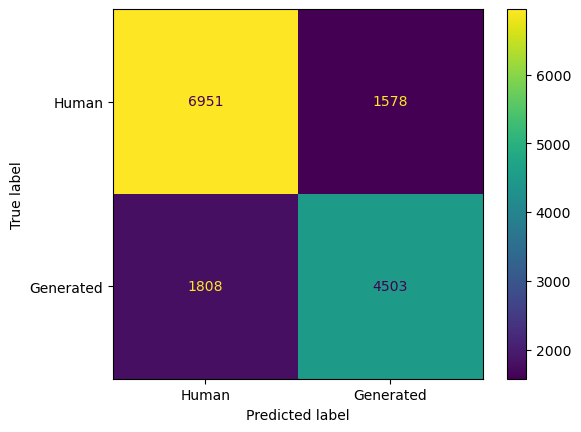

In [56]:
### SVM model
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib  

svm_model = LinearSVC()
svm_model.fit(train_x_tfidf, train_y)  # Train the model with training data

valid_pred_y = svm_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = svm_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(svm_model, 'svm_model_Traditional.joblib')


Validation Accuracy:  0.6820882852292021
Validation F1 Score:  0.6299145902449355
Validation MCC:  0.3513688124565124
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72      9344
           1       0.64      0.62      0.63      7148

    accuracy                           0.68     16492
   macro avg       0.68      0.68      0.68     16492
weighted avg       0.68      0.68      0.68     16492

Test Accuracy:  0.7072776280323451
Test F1 Score:  0.6455613577023499
Test MCC:  0.3971420592471774
Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75      8529
           1       0.67      0.63      0.65      6311

    accuracy                           0.71     14840
   macro avg       0.70      0.70      0.70     14840
weighted avg       0.71      0.71      0.71     14840



['knn_model_Traditional.joblib']

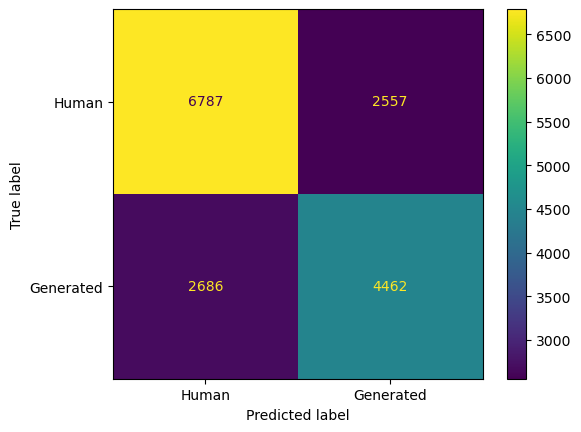

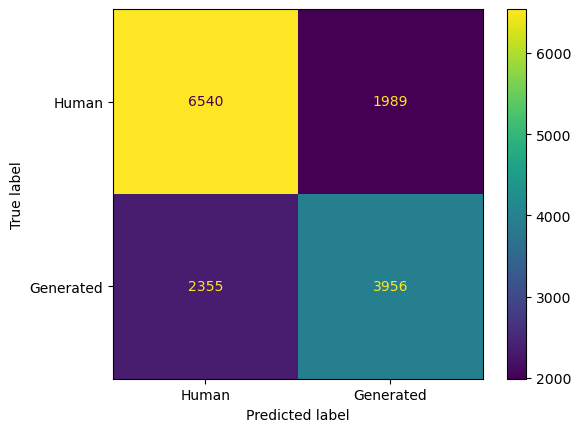

In [57]:
### KNN model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib  

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_x_tfidf, train_y)

valid_pred_y = knn_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = knn_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(knn_model, 'knn_model_Traditional.joblib')


Validation Accuracy:  0.737084647101625
Validation F1 Score:  0.6955911260881775
Validation MCC:  0.46422940238531396
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      9344
           1       0.70      0.69      0.70      7148

    accuracy                           0.74     16492
   macro avg       0.73      0.73      0.73     16492
weighted avg       0.74      0.74      0.74     16492

Test Accuracy:  0.7283692722371967
Test F1 Score:  0.6775457963362931
Test MCC:  0.44299875966654206
Test Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      8529
           1       0.68      0.67      0.68      6311

    accuracy                           0.73     14840
   macro avg       0.72      0.72      0.72     14840
weighted avg       0.73      0.73      0.73     14840



['decision_tree_model_Traditional.joblib']

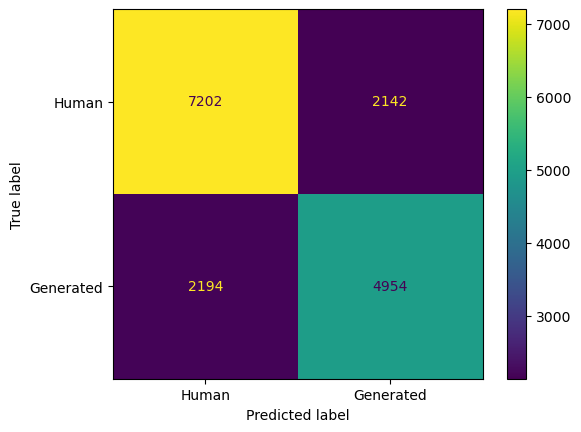

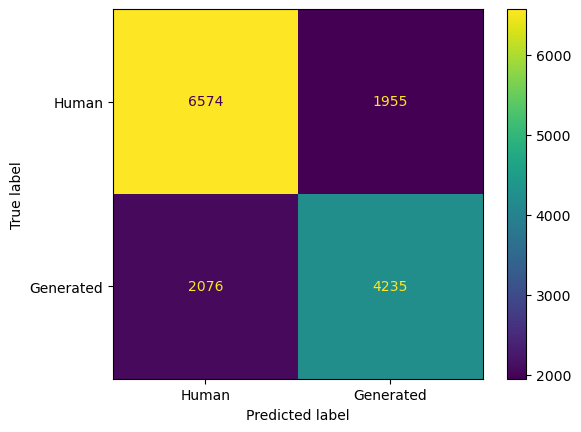

In [58]:
### Decision Tree model

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib  

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(train_x_tfidf, train_y)

valid_pred_y = dt_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = dt_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(dt_model, 'decision_tree_model_Traditional.joblib')


Validation Accuracy:  0.7310817365995634
Validation F1 Score:  0.676725708870909
Validation MCC:  0.4483728770669848
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77      9344
           1       0.71      0.65      0.68      7148

    accuracy                           0.73     16492
   macro avg       0.73      0.72      0.72     16492
weighted avg       0.73      0.73      0.73     16492

Test Accuracy:  0.7181940700808626
Test F1 Score:  0.6513837945981994
Test MCC:  0.41757642588497
Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      8529
           1       0.69      0.62      0.65      6311

    accuracy                           0.72     14840
   macro avg       0.71      0.71      0.71     14840
weighted avg       0.72      0.72      0.72     14840



['adaboost_model_Traditional.joblib']

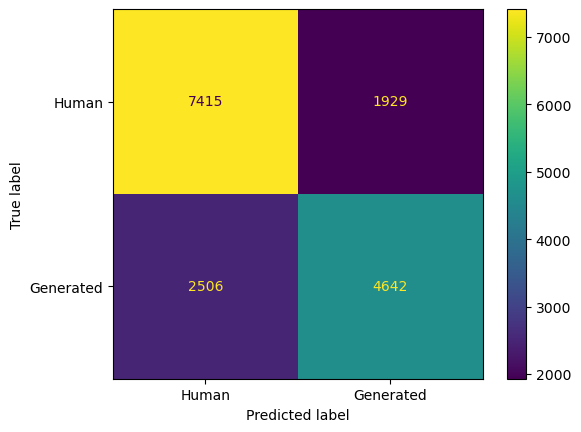

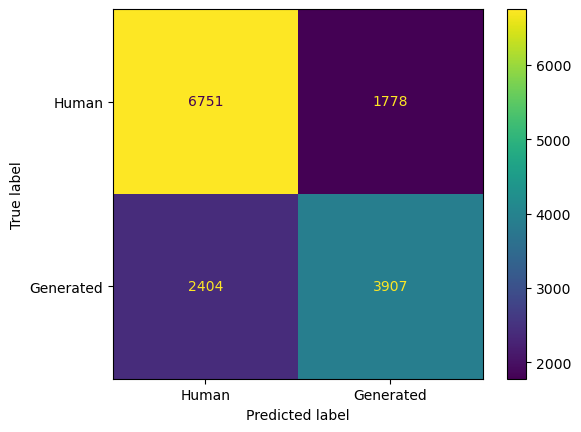

In [60]:
### Adaboost model

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib  

dt_stump = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_model = AdaBoostClassifier(estimator=dt_stump, n_estimators=100, algorithm='SAMME', random_state=42)
ada_model.fit(train_x_tfidf, train_y)

valid_pred_y = ada_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = ada_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(ada_model, 'adaboost_model_Traditional.joblib')


In [5]:
#### Bagging Classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(train_x_tfidf, train_y)

valid_pred_y = bagging_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

test_pred_y = bagging_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

KeyboardInterrupt: 

In [39]:
### Bagging Classifier model

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib  

base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(train_x_tfidf, train_y)

valid_pred_y = bagging_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = bagging_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(bagging_model, 'bagging_model_Traditional.joblib')


KeyboardInterrupt: 

In [ ]:
### Gradient Boosting Classifier model

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gradient_boosting_model.fit(train_x_tfidf, train_y)

valid_pred_y = gradient_boosting_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = gradient_boosting_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(gradient_boosting_model, 'gradient_boosting_model_Traditional.joblib')


Validation Accuracy:  0.7985083676934271
Validation F1 Score:  0.7496044005726773
Validation MCC:  0.5875991508421087
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      9344
           1       0.81      0.70      0.75      7148

    accuracy                           0.80     16492
   macro avg       0.80      0.79      0.79     16492
weighted avg       0.80      0.80      0.80     16492

Test Accuracy:  0.8057951482479785
Test F1 Score:  0.7438222222222223
Test MCC:  0.6026841260532657
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84      8529
           1       0.85      0.66      0.74      6311

    accuracy                           0.81     14840
   macro avg       0.82      0.79      0.79     14840
weighted avg       0.81      0.81      0.80     14840



['random_forest_model_Traditional.joblib']

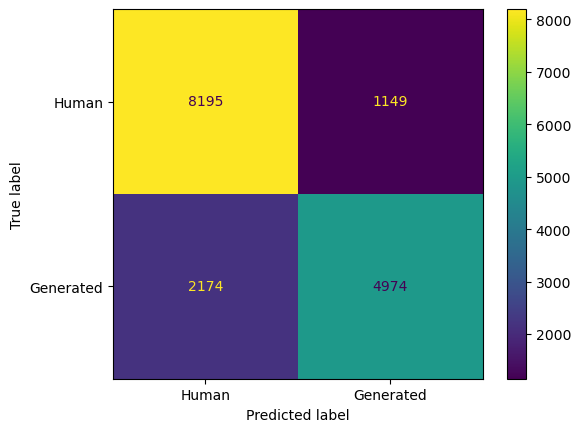

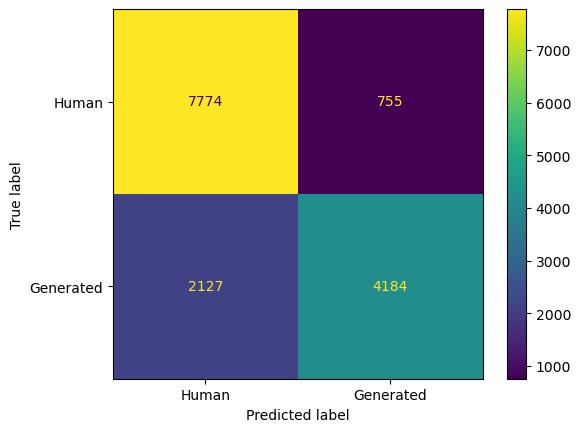

In [28]:
### Random Forest Classifier Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(train_x_tfidf, train_y)

valid_pred_y = rf_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = rf_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(rf_model, 'random_forest_model_Traditional.joblib')


Validation Accuracy:  0.7872908076643221
Validation F1 Score:  0.7399555226093403
Validation MCC:  0.5639619702402601
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      9344
           1       0.79      0.70      0.74      7148

    accuracy                           0.79     16492
   macro avg       0.79      0.78      0.78     16492
weighted avg       0.79      0.79      0.79     16492

Test Accuracy:  0.8120619946091644
Test F1 Score:  0.7521990226565971
Test MCC:  0.6160863255318844
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      8529
           1       0.86      0.67      0.75      6311

    accuracy                           0.81     14840
   macro avg       0.82      0.79      0.80     14840
weighted avg       0.82      0.81      0.81     14840



['extra_trees_model_Traditional.joblib']

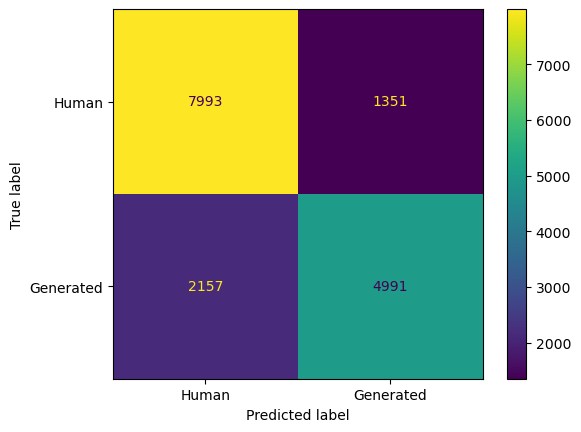

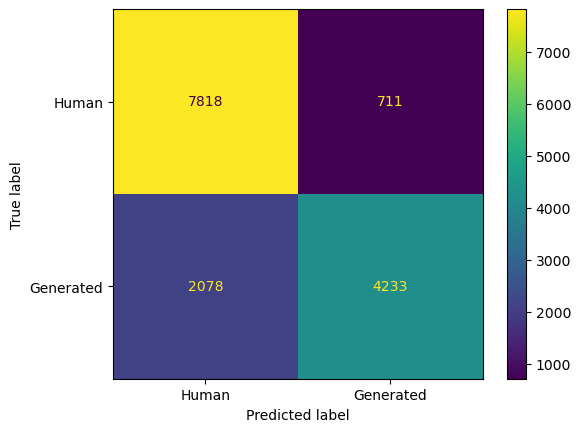

In [37]:
### Extra Tree Classifier model

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_model.fit(train_x_tfidf, train_y)

valid_pred_y = extra_trees_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = extra_trees_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(extra_trees_model, 'extra_trees_model_Traditional.joblib')


Validation Accuracy:  0.7804390007276255
Validation F1 Score:  0.7446943523937107
Validation MCC:  0.5521735985368855
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      9344
           1       0.75      0.74      0.74      7148

    accuracy                           0.78     16492
   macro avg       0.78      0.78      0.78     16492
weighted avg       0.78      0.78      0.78     16492

Test Accuracy:  0.771832884097035
Test F1 Score:  0.7255633003728319
Test MCC:  0.5309035717040899
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80      8529
           1       0.74      0.71      0.73      6311

    accuracy                           0.77     14840
   macro avg       0.77      0.76      0.77     14840
weighted avg       0.77      0.77      0.77     14840



['logistic_regression_model_Traditional.joblib']

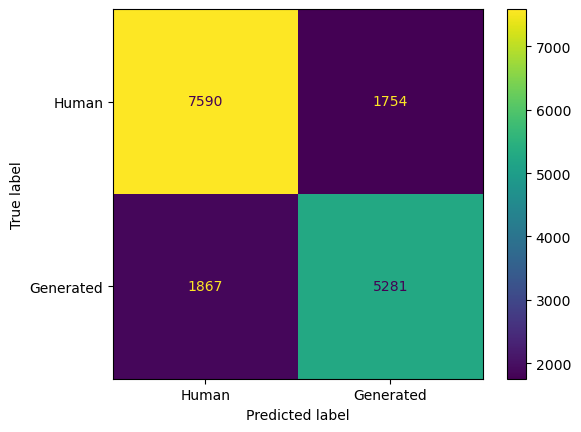

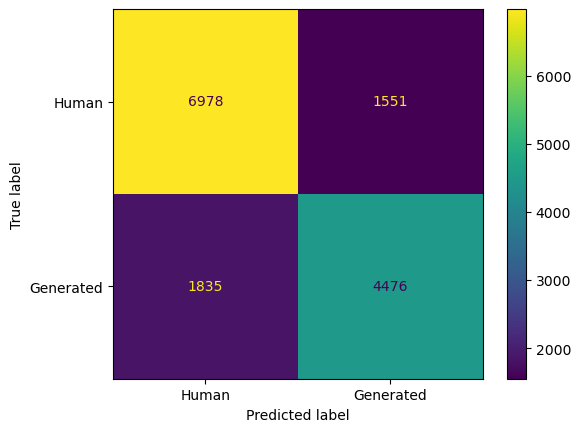

In [29]:
### Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_x_tfidf, train_y)

valid_pred_y = log_reg.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = log_reg.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(log_reg, 'logistic_regression_model_Traditional.joblib')


Validation Accuracy:  0.7794688333737569
Validation F1 Score:  0.7499484358886215
Validation MCC:  0.5530661168591118
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      9344
           1       0.74      0.76      0.75      7148

    accuracy                           0.78     16492
   macro avg       0.78      0.78      0.78     16492
weighted avg       0.78      0.78      0.78     16492

Test Accuracy:  0.7921832884097035
Test F1 Score:  0.754653937947494
Test MCC:  0.5744286080213709
Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      8529
           1       0.76      0.75      0.75      6311

    accuracy                           0.79     14840
   macro avg       0.79      0.79      0.79     14840
weighted avg       0.79      0.79      0.79     14840



['mlp_model_Traditional.joblib']

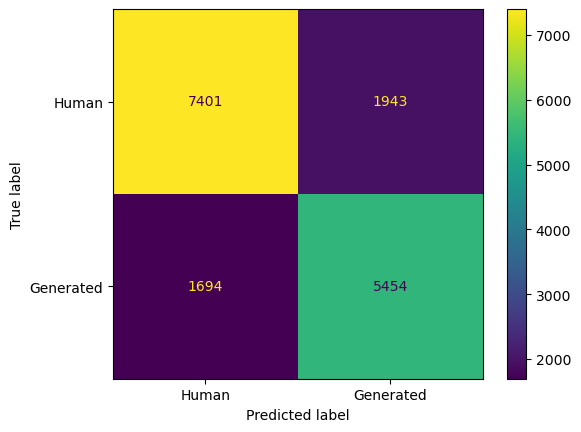

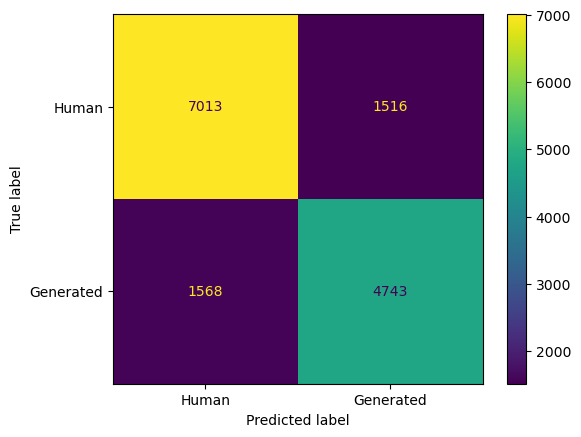

In [38]:
### Multi Layer Perceptron model

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(train_x_tfidf, train_y)

valid_pred_y = mlp_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = mlp_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(mlp_model, 'mlp_model_Traditional.joblib')


Validation Accuracy:  0.7771040504487025
Validation F1 Score:  0.7382512104813443
Validation MCC:  0.5445392281989464
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      9344
           1       0.75      0.73      0.74      7148

    accuracy                           0.78     16492
   macro avg       0.77      0.77      0.77     16492
weighted avg       0.78      0.78      0.78     16492

Test Accuracy:  0.7669811320754717
Test F1 Score:  0.7164179104477612
Test MCC:  0.5199949165743254
Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      8529
           1       0.74      0.69      0.72      6311

    accuracy                           0.77     14840
   macro avg       0.76      0.76      0.76     14840
weighted avg       0.77      0.77      0.77     14840



['lda_model_Traditional.joblib']

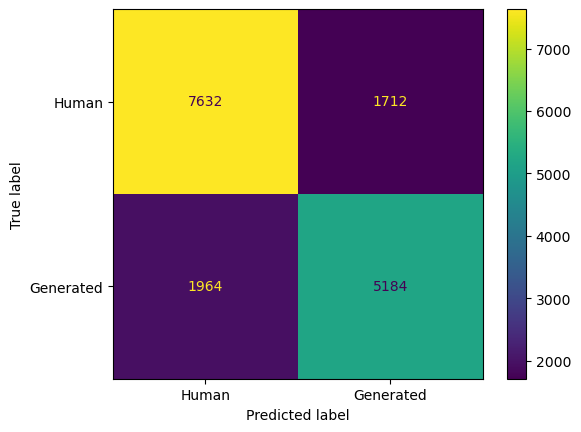

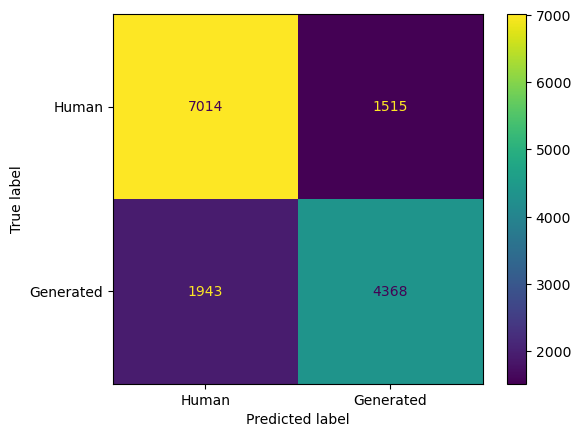

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    matthews_corrcoef
)
import joblib

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_x_tfidf, train_y)  

valid_pred_y = lda_model.predict(valid_x_tfidf)

print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))
print("Validation F1 Score: ", f1_score(valid_y, valid_pred_y))
print("Validation MCC: ", matthews_corrcoef(valid_y, valid_pred_y))

cmd_valid = ConfusionMatrixDisplay(confusion_matrix(valid_y, valid_pred_y), display_labels=['Human', 'Generated'])
cmd_valid.plot()

report_valid = classification_report(valid_y, valid_pred_y)
print("Validation Classification Report:\n", report_valid)

test_pred_y = lda_model.predict(test_x_tfidf)

print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))
print("Test F1 Score: ", f1_score(test_y, test_pred_y))
print("Test MCC: ", matthews_corrcoef(test_y, test_pred_y))

cmd_test = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd_test.plot()

report_test = classification_report(test_y, test_pred_y)
print("Test Classification Report:\n", report_test)

joblib.dump(lda_model, 'lda_model_Traditional.joblib')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(12, 8))

# CNN Model
valid_pred_prob_cnn = model_CNN.predict(valid_x_tfidf_reshaped).flatten()
test_pred_prob_cnn = model_CNN.predict(test_x_tfidf_reshaped).flatten()
plot_roc_curve(valid_y, valid_pred_prob_cnn, 'CNN Validation')
plot_roc_curve(test_y, test_pred_prob_cnn, 'CNN Test')

# LSTM Model
valid_pred_prob_lstm = model_LSTM.predict(valid_dataset).flatten()
test_pred_prob_lstm = model_LSTM.predict(test_dataset).flatten()
plot_roc_curve(valid_y, valid_pred_prob_lstm, 'LSTM Validation')
plot_roc_curve(test_y, test_pred_prob_lstm, 'LSTM Test')

# RNN Model
valid_pred_prob_rnn = model_RNN.predict(valid_dataset).flatten()
test_pred_prob_rnn = model_RNN.predict(test_dataset).flatten()
plot_roc_curve(valid_y, valid_pred_prob_rnn, 'RNN Validation')
plot_roc_curve(test_y, test_pred_prob_rnn, 'RNN Test')

# SVM Model
valid_pred_prob_svm = svm_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_svm = svm_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_svm, 'SVM Validation')
plot_roc_curve(test_y, test_pred_prob_svm, 'SVM Test')

# KNN Model
valid_pred_prob_knn = knn_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_knn = knn_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_knn, 'KNN Validation')
plot_roc_curve(test_y, test_pred_prob_knn, 'KNN Test')

# Decision Tree Model
valid_pred_prob_dt = dt_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_dt = dt_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_dt, 'Decision Tree Validation')
plot_roc_curve(test_y, test_pred_prob_dt, 'Decision Tree Test')

# AdaBoost Model
valid_pred_prob_ab = ada_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_ab = ada_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_ab, 'AdaBoost Validation')
plot_roc_curve(test_y, test_pred_prob_ab, 'AdaBoost Test')

# Bagging Classifier Model
valid_pred_prob_bagging = bagging_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_bagging = bagging_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_bagging, 'Bagging Validation')
plot_roc_curve(test_y, test_pred_prob_bagging, 'Bagging Test')

# Gradient Boosting Model
valid_pred_prob_gb = gb_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_gb = gb_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_gb, 'Gradient Boosting Validation')
plot_roc_curve(test_y, test_pred_prob_gb, 'Gradient Boosting Test')

# Random Forest Model
valid_pred_prob_rf = rf_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_rf = rf_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_rf, 'Random Forest Validation')
plot_roc_curve(test_y, test_pred_prob_rf, 'Random Forest Test')

# Extra Trees Model
valid_pred_prob_et = et_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_et = et_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_et, 'Extra Trees Validation')
plot_roc_curve(test_y, test_pred_prob_et, 'Extra Trees Test')

# Logistic Regression Model
valid_pred_prob_lr = lr_model.predict_proba(valid_x_tfidf)[:, 1]
test_pred_prob_lr = lr_model.predict_proba(test_x_tfidf)[:, 1]
plot_roc_curve(valid_y, valid_pred_prob_lr, 'Logistic Regression Validation')
plot_roc_curve(test_y, test_pred_prob_lr, 'Logistic Regression Test')

# Multi-Layer Perceptron Model
valid_pred_prob_mlp = mlp_model.predict(valid_x_tfidf).flatten()
test_pred_prob_mlp = mlp_model.predict(test_x_tfidf).flatten()
plot_roc_curve(valid_y, valid_pred_prob_mlp, 'Multi-Layer Perceptron Validation')
plot_roc_curve(test_y, test_pred_prob_mlp, 'Multi-Layer Perceptron Test')

# Finalize the plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [48]:
# Check the correct input shape for CNN
print(train_x_tfidf.shape)  # Make sure it's (samples, features)

# Reshape to 3D for Conv1D input
train_x_tfidf_reshaped = train_x_tfidf.reshape((train_x_tfidf.shape[0], train_x_tfidf.shape[1], 1))
valid_x_tfidf_reshaped = valid_x_tfidf.reshape((valid_x_tfidf.shape[0], valid_x_tfidf.shape[1], 1))
test_x_tfidf_reshaped = test_x_tfidf.reshape((test_x_tfidf.shape[0], test_x_tfidf.shape[1], 1))


(148402, 1000)


In [53]:
from tensorflow.keras.models import load_model

model_CNN = load_model('model_CNN_Traditional.h5')
model_LSTM = load_model('model_LSTM_Traditional.h5')
model_RNN = load_model('model_RNN_Traditional.h5')
svm_model = joblib.load('svm_model_Traditional.joblib')
knn_model = joblib.load('knn_model_Traditional.joblib')



KeyboardInterrupt: 

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

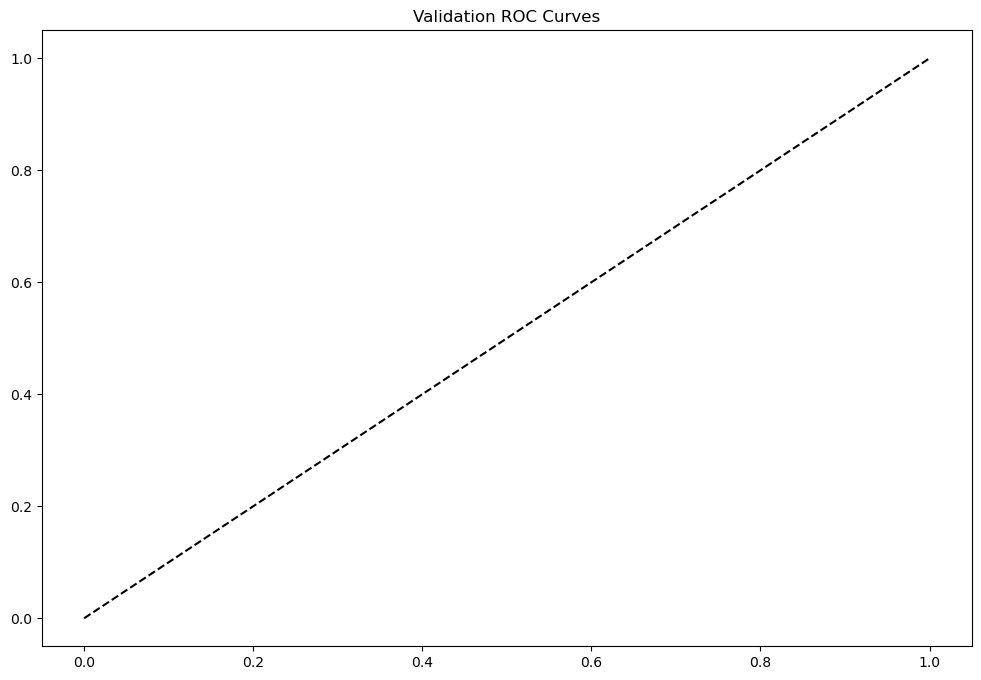

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot for Validation ROC Curves
plt.figure(figsize=(12, 8))
plt.title('Validation ROC Curves')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# CNN Model Validation
# plot_roc_curve(valid_y, model_CNN.predict(valid_x_tfidf_reshaped).flatten(), 'CNN Validation')

# LSTM Model Validation
# plot_roc_curve(valid_y, model_LSTM.predict(valid_dataset).flatten(), 'LSTM Validation')

# RNN Model Validation
# plot_roc_curve(valid_y, model_RNN.predict(valid_dataset).flatten(), 'RNN Validation')

# SVM Model Validation
plot_roc_curve(valid_y, svm_model.predict(valid_x_tfidf)[:, 1], 'SVM Validation')

# KNN Model Validation
plot_roc_curve(valid_y, knn_model.predict(valid_x_tfidf)[:, 1], 'KNN Validation')

# Decision Tree Model Validation
plot_roc_curve(valid_y, dt_model.predict(valid_x_tfidf)[:, 1], 'Decision Tree Validation')

# AdaBoost Model Validation
# plot_roc_curve(valid_y, ada_model.predict_proba(valid_x_tfidf)[:, 1], 'AdaBoost Validation')

# Bagging Model Validation
# plot_roc_curve(valid_y, bagging_model.predict_proba(valid_x_tfidf)[:, 1], 'Bagging Validation')

# Gradient Boosting Model Validation
# plot_roc_curve(valid_y, gb_model.predict_proba(valid_x_tfidf)[:, 1], 'Gradient Boosting Validation')

# Random Forest Model Validation
plot_roc_curve(valid_y, rf_model.predict_proba(valid_x_tfidf)[:, 1], 'Random Forest Validation')

# Extra Trees Model Validation
plot_roc_curve(valid_y, et_model.predict_proba(valid_x_tfidf)[:, 1], 'Extra Trees Validation')

# Logistic Regression Model Validation
plot_roc_curve(valid_y, lr_model.predict_proba(valid_x_tfidf)[:, 1], 'Logistic Regression Validation')

# Multi-Layer Perceptron Model Validation
plot_roc_curve(valid_y, mlp_model.predict(valid_x_tfidf).flatten(), 'MLP Validation')
plot_roc_curve(valid_y, lda_model.predict(valid_x_tfidf).flatten(), 'LDA Validation')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot for Test ROC Curves


In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test ROC Curves')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# CNN Model Test
# plot_roc_curve(test_y, model_CNN.predict(test_x_tfidf_reshaped).flatten(), 'CNN Test')

# LSTM Model Test
# plot_roc_curve(test_y, model_LSTM.predict(test_dataset).flatten(), 'LSTM Test')

# RNN Model Test
# plot_roc_curve(test_y, model_RNN.predict(test_dataset).flatten(), 'RNN Test')

# SVM Model Test
# plot_roc_curve(test_y, svm_model.predict_proba(test_x_tfidf)[:, 1], 'SVM Test')

# KNN Model Test
# plot_roc_curve(test_y, knn_model.predict_proba(test_x_tfidf)[:, 1], 'KNN Test')

# Decision Tree Model Test
# plot_roc_curve(test_y, dt_model.predict_proba(test_x_tfidf)[:, 1], 'Decision Tree Test')

# # AdaBoost Model Test
# plot_roc_curve(test_y, ada_model.predict_proba(test_x_tfidf)[:, 1], 'AdaBoost Test')

# # Bagging Model Test
# plot_roc_curve(test_y, bagging_model.predict_proba(test_x_tfidf)[:, 1], 'Bagging Test')

# # Gradient Boosting Model Test
# plot_roc_curve(test_y, gb_model.predict_proba(test_x_tfidf)[:, 1], 'Gradient Boosting Test')

# # Random Forest Model Test
# plot_roc_curve(test_y, rf_model.predict_proba(test_x_tfidf)[:, 1], 'Random Forest Test')

# # Extra Trees Model Test
# plot_roc_curve(test_y, et_model.predict_proba(test_x_tfidf)[:, 1], 'Extra Trees Test')

# # Logistic Regression Model Test
# plot_roc_curve(test_y, lr_model.predict_proba(test_x_tfidf)[:, 1], 'Logistic Regression Test')

# # Multi-Layer Perceptron Model Test
# plot_roc_curve(test_y, mlp_model.predict(test_x_tfidf).flatten(), 'MLP Test')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming y_true contains the true labels for the test set
# Replace this with your actual true labels
y_true = test_y 

# Calculate the accuracies for each model
test_accuracies = [
    accuracy_score(y_true, (test_pred_prob_cnn > 0.5).astype(int)),  # CNN
    accuracy_score(y_true, (test_pred_prob_lstm > 0.5).astype(int)),  # LSTM
    accuracy_score(y_true, (test_pred_prob_rnn > 0.5).astype(int)),  # RNN
    accuracy_score(y_true, (test_pred_prob_svm > 0.5).astype(int)),  # SVM
    accuracy_score(y_true, (test_pred_prob_knn > 0.5).astype(int)),  # KNN
    accuracy_score(y_true, (test_pred_prob_dt > 0.5).astype(int)),  # Decision Tree
    accuracy_score(y_true, (test_pred_prob_ab > 0.5).astype(int)),  # AdaBoost
    accuracy_score(y_true, (test_pred_prob_bagging > 0.5).astype(int)),  # Bagging
    accuracy_score(y_true, (test_pred_prob_gb > 0.5).astype(int)),  # Gradient Boosting
    accuracy_score(y_true, (test_pred_prob_rf > 0.5).astype(int)),  # Random Forest
    accuracy_score(y_true, (test_pred_prob_et > 0.5).astype(int)),  # Extra Trees
    accuracy_score(y_true, (test_pred_prob_lr > 0.5).astype(int)),  # Logistic Regression
    accuracy_score(y_true, (test_pred_prob_mlp > 0.5).astype(int)),  # Multi-Layer Perceptron
]

# Model names for the bar graph
model_names = [
    'CNN', 'LSTM', 'RNN', 'SVM', 'KNN', 'Decision Tree', 
    'AdaBoost', 'Bagging', 'Gradient Boosting', 
    'Random Forest', 'Extra Trees', 'Logistic Regression', 
    'Multi-Layer Perceptron'
]

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.barh(model_names, test_accuracies, color='skyblue')
plt.xlabel('Test Accuracy')
plt.title('Test Accuracies of Different Models')
plt.xlim([0, 1])  # Set x-axis limits to 0 to 1 for accuracy
plt.grid(axis='x')

# Display the accuracy values on the bars
for i, v in enumerate(test_accuracies):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

plt.show()
